In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pylab as plt
from skimage import io
from skimage.data import rocket

In [4]:
from stretchablecorr.stretchablecorr import crop

In [8]:
from stretchablecorr import *

(427, 640, 3)
(150, 322)


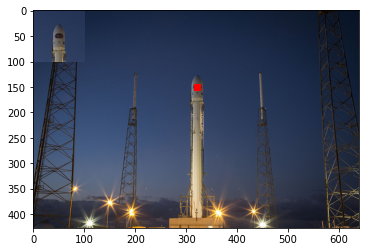

In [9]:
# ======
#  Crop
# ======
x, y = (322, 150)
plt.imshow(rocket());
print(rocket().shape)
plt.plot(x, y, 'sr');
C, ij = crop(rocket(), (x, y), 50)
plt.imshow(C);
print(ij)

In [10]:
C, ij = crop(rocket(), (322.2, 150.8), 50)
print(ij)

(151, 322)


In [11]:
# ============
#  get shifts
# ============

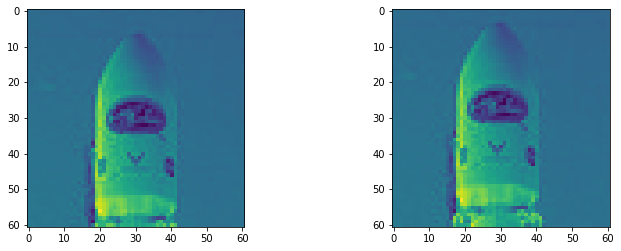

In [12]:
I = rocket().mean(axis=2)

window_half_size = 30
A, ij = crop(I, (322, 150), window_half_size)
B, ij = crop(I, (323, 153), window_half_size)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,4))
ax1.imshow(A);
ax2.imshow(B);
# true shifts  = -1, -3

In [13]:
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=15,
           offset=(0.0, 0.0),
           coarse_search=False,
           upsample_factor=100,
           method='skimage')

(-1.01, -2.93, 0.11381233475481252)

In [14]:
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=10,
           offset=(0.0, 0.0),
           coarse_search=True,
           upsample_factor=100,
           method='skimage')

(-1.0, -3.0, 1.8250120749944284e-08)

In [15]:
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=10,
           coarse_search=True,
           method='opti')

(-1.0, -3.0, -21.02385009286531)

### Benchmark

In [16]:
%%timeit
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=10,
           coarse_search=True,
           method='opti')

# 2.1 ms ± 18.8 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 1.88 ms ± 8.03 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)

1.95 ms ± 43.3 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [17]:
%%timeit
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=10,
           coarse_search=False,
           method='opti')

# 3.09 ms ± 35.4 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
# 1.25 ms ± 22 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
# 766 µs ± 140 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)  with jit

802 µs ± 10.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [18]:
%%timeit
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=10,
           upsample_factor=100,
           coarse_search=True,
           method='skimage')

6.86 ms ± 415 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [19]:
%%timeit
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=10,
           upsample_factor=100,
           coarse_search=False,
           method='skimage')

3.97 ms ± 986 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### Error estimation

In [103]:
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=10,
           coarse_search=False,
           method='opti')

(-0.992894024379066, -2.951424874754895, -0.7290908954273946)

In [122]:
get_shifts(A, B, window_half_size, window_half_size,
           window_half_size=5,
           coarse_search=False,
           method='opti')

(-1.0506550307052493, -2.6538980732875066, 2.0221801122090928)

In [123]:
def sample(window_half_size, sigma, phase):    
    B_prime = B + sigma*np.std(B)*np.random.randn(*B.shape)
    x, y = np.array(A.T.shape)/2
    dx, dy, err = get_shifts(A, B_prime, x, y,
                             window_half_size=window_half_size,
                             coarse_search=False,
                             phase=phase,
                             method='opti')
    return dx, dy, err

In [127]:
def estimate(window_half_size, sigma, phase, N=100):
    dxy_err = np.vstack([sample(16, sigma=sigma, phase=phase) for _ in range(N)])
    dxy = dxy_err[:, :2]
    eps_MC = np.sqrt(np.sum((dxy - dxy.mean(axis=0))**2, axis=1)).mean()
    
    err_estimate = dxy_err[:, 2]
    
    return eps_MC, err_estimate.mean()

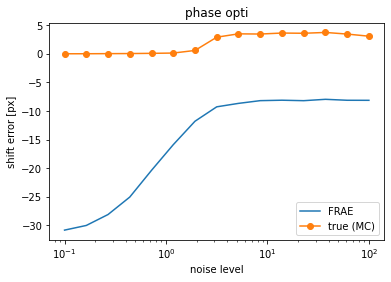

In [139]:
sigma_span = np.logspace(-1, 2, 15)
errs = np.vstack([estimate(15, s, phase=True, N=100) for s in sigma_span])

plt.title('phase opti')
plt.semilogx(sigma_span, errs[:, 1], label='FRAE')
plt.semilogx(sigma_span, errs[:, 0],  '-o', label='true (MC)');
plt.legend(); plt.ylabel('shift error [px]'); plt.xlabel('noise level');

In [141]:
sigma_span = np.logspace(-1, 2, 15)
errs = np.vstack([estimate(15, s, phase=False, N=100) for s in sigma_span])

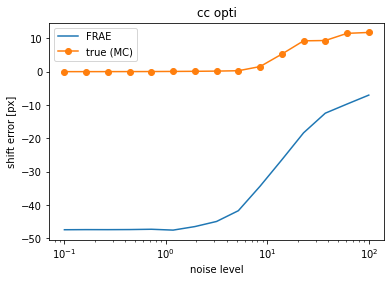

In [142]:
plt.title('cc opti')
plt.semilogx(sigma_span, errs[:, 1], label='FRAE')
plt.semilogx(sigma_span, errs[:, 0],  '-o', label='true (MC)');
plt.legend(); plt.ylabel('shift error [px]'); plt.xlabel('noise level');

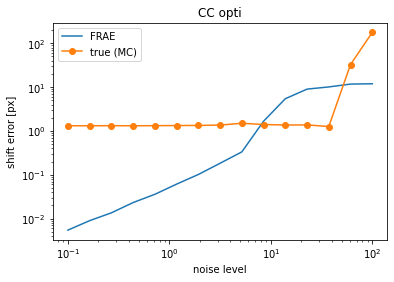

In [100]:
sigma_span = np.logspace(-1, 2, 15)
errs = np.vstack([estimate(15, s, phase=False, N=100) for s in sigma_span])

plt.title('CC opti')
plt.loglog(sigma_span, errs[:, 0], label='FRAE')
plt.loglog(sigma_span, errs[:, 1],  '-o', label='true (MC)');
plt.legend(); plt.ylabel('shift error [px]'); plt.xlabel('noise level');